In [33]:
# Importing the libraries
import time
import numpy as np # for array operations
import pandas as pd # for working with DataFrames

# scikit-learn modules
from sklearn.model_selection import train_test_split # for splitting the data
from sklearn.metrics import mean_squared_error # for calculating the cost function
from sklearn.ensemble import RandomForestRegressor # for building the model

In [34]:
DATE_TIME_COLUMNS = ['DATETIME_INI', 'DATETIME_FIM']

dataset = pd.read_csv('../../../data/preprocessed.csv', index_col='PES_ID', parse_dates=DATE_TIME_COLUMNS)

In [35]:
dataset["DATETIME_INI"] = dataset["DATETIME_INI"].apply(lambda x: time.mktime(x.timetuple()))
dataset["DATETIME_FIM"] = dataset["DATETIME_FIM"].apply(lambda x: time.mktime(x.timetuple()))

In [42]:
dataset.head()

,LOCDESCARREGO_ID,EMP_ID,ROTA_ID,TPVEICULO_DESC,PES_PESOUTIL,COLETA_ID,ESPECCOLETA_ID,PERCUSSO_I,LOCAL_ID,TPCIRCUITO_DESC,DATETIME_INI,DATETIME_FIM
PES_ID,,,,,,,,,,,,
2490322,7,708,144,3,9640,1,1,2156.0,205,0,1.420081e+09,1.420082e+09
2489495,7,708,144,3,9100,1,1,2156.0,205,0,1.419914e+09,1.419915e+09
2488707,7,708,144,3,3480,1,1,2156.0,205,0,1.419666e+09,1.419667e+09
2488660,7,708,144,3,9370,1,1,2156.0,205,0,1.419655e+09,1.419655e+09
2488114,7,708,144,3,9460,1,1,2156.0,205,0,1.419502e+09,1.419503e+09


In [36]:
x = dataset.drop('PES_PESOUTIL', axis = 1) # Features
y = dataset['PES_PESOUTIL']  # Target

In [37]:
# Splitting the dataset into training and testing set (70/30)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

In [38]:
# Initializing the Random Forest Regression model with 10 decision trees
model = RandomForestRegressor(n_estimators = 10, random_state = 0)

# Fitting the Random Forest Regression model to the data
model.fit(x_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=0)

In [39]:
# MSE (Mean Squared Error)
mse = mean_squared_error(y_test, model.predict(x_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 6994586.5993


## Cross-Validation

In [46]:
import random
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import ShuffleSplit

def cross_validate_model(model, X, y, cv=10):
    cv = ShuffleSplit(n_splits=cv, test_size=0.3, random_state=random.randint(0, 1000))
    n_scores = cross_validate(estimator=model,
                            X=X,
                            y=y,
                            cv=cv,
                            scoring=('r2', 'neg_mean_squared_error', 'neg_root_mean_squared_error'),
                            return_train_score=True)
    return n_scores

## Experimentation

In [47]:
N_ITERATIONS = 5
N_CROSS_VALIDATION = 10

n_scores = []

for _ in range(N_ITERATIONS):
    n_scores.append(cross_validate_model(model, x, y, cv=N_CROSS_VALIDATION))

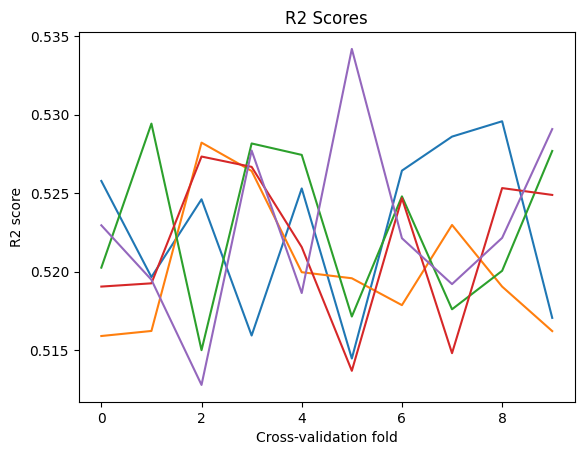

In [49]:
import matplotlib.pyplot as plt

# print(n_scores)
# Reshape the R2 scores
r2_scores = [r2['test_r2'].reshape(-1, 1) for r2 in n_scores]

# Plot the R2 scores
[plt.plot(r2_score, label=f'Fold {i + 1}') for i, r2_score in enumerate(r2_scores)]
plt.xlabel('Cross-validation fold')
plt.ylabel('R2 score')
plt.title('R2 Scores')
plt.show()

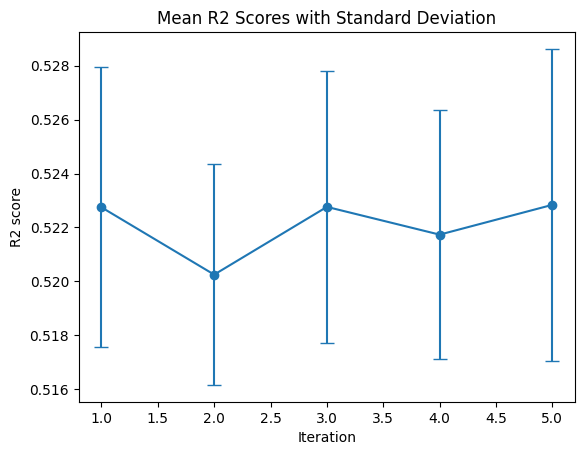

Mean R2: 0.5221
Standard Deviation of R2: 0.0010


In [51]:
# Calculate mean and standard deviation of R2 scores
mean_r2_scores = [r2['test_r2'].mean() for r2 in n_scores]
std_r2_scores = [r2['test_r2'].std() for r2 in n_scores]

# Plot the mean R2 scores with error bars representing the standard deviation
plt.errorbar(range(1, N_ITERATIONS + 1), mean_r2_scores, yerr=std_r2_scores, marker='o', linestyle='-', capsize=5)
plt.xlabel('Iteration')
plt.ylabel('R2 score')
plt.title('Mean R2 Scores with Standard Deviation')
plt.show()

mean_r2 = sum(mean_r2_scores) / len(mean_r2_scores)
std_mse = np.std(mean_r2_scores)

print("Mean R2: {:.4f}".format(mean_r2))
print("Standard Deviation of R2: {:.4f}".format(std_mse))

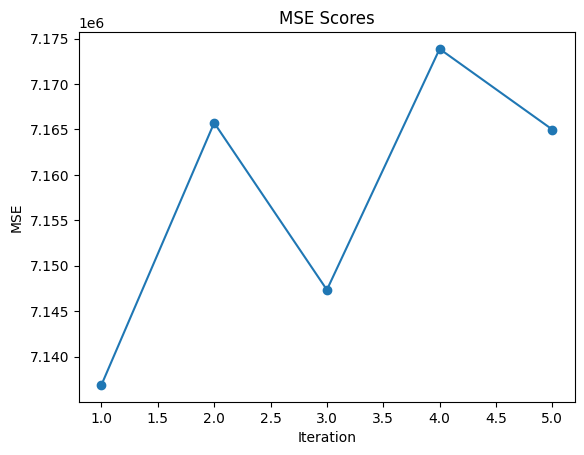

Mean MSE: 7157763.9671
Standard Deviation of MSE: 13563.0914


In [52]:
# Calculate MSE for each fold
mse_scores = [-r2['test_neg_mean_squared_error'].mean() for r2 in n_scores]

# Plot the MSE scores
plt.plot(range(1, N_ITERATIONS + 1), mse_scores, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.title('MSE Scores')
plt.show()

# Calculate mean and standard deviation of MSE scores
mean_mse = sum(mse_scores) / len(mse_scores)
std_mse = np.std(mse_scores)

print("Mean MSE: {:.4f}".format(mean_mse))
print("Standard Deviation of MSE: {:.4f}".format(std_mse))

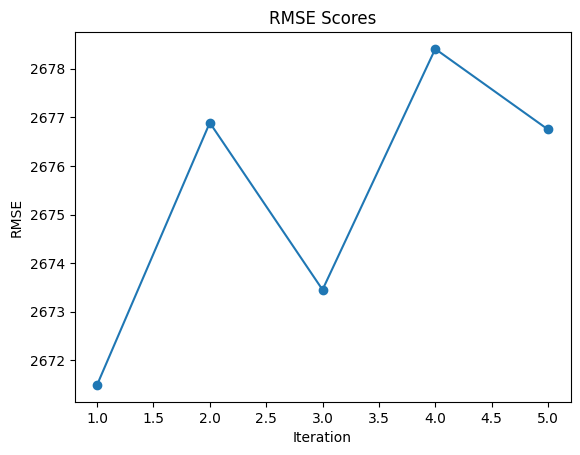

Mean RMSE: 2675.3986
Standard Deviation of RMSE: 2.5353


In [53]:
rmse_scores = [np.sqrt(-r2['test_neg_mean_squared_error'].mean()) for r2 in n_scores]

# Plot the RMSE scores
plt.plot(range(1, N_ITERATIONS + 1), rmse_scores, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('RMSE Scores')
plt.show()

# Calculate mean and standard deviation of RMSE scores
mean_rmse = sum(rmse_scores) / len(rmse_scores)
std_rmse = np.std(rmse_scores)

print("Mean RMSE: {:.4f}".format(mean_rmse))
print("Standard Deviation of RMSE: {:.4f}".format(std_rmse))